In [40]:
import jax
import jax.numpy as jnp
import jax.random as random
import jax.scipy as scipy
from scipy.integrate import RK45
import numpy as np
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from jax import grad, jit, vmap, jvp, vjp, jacrev, jacfwd
import sys
import pickle
sys.path.append("..")
key = random.PRNGKey(0)

In [41]:


class AdamOptim:
    def __init__(self, eta, beta1, beta2, epsilon, params):
        self.m = jax.tree_map(lambda m: 0.0, params)
        self.v = jax.tree_map(lambda m: 0.0, params)
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.eta = eta
    def update(self, params, grads, t):
        self.m = jax.tree_map(lambda m, grads: self.beta1*m + (1-self.beta1)*grads, self.m, grads)
        self.v = jax.tree_map(lambda v, grads: self.beta2*v + (1-self.beta2)*(grads**2), self.v, grads)
        m_hat = jax.tree_map(lambda m: m/(1 - self.beta1**t), self.m)
        v_hat = jax.tree_map(lambda v: v/(1 - self.beta2**t), self.v)
        params = jax.tree_map(lambda p, m, v: p -  self.eta* m/(jnp.sqrt(v) + self.epsilon), params, m_hat, v_hat)
        return(params)

## The functional intializes both FICNN and PICNN 

def init_icnn_params(x_layer_widths, y_layer_widths, picnn = True):
  params = []
  for n_in_x, n_out_x, n_in_y, n_out_y in zip(x_layer_widths[:-1], x_layer_widths[1:], y_layer_widths[:-1], y_layer_widths[1:]):
    if(picnn):
      params.append(
          dict(weights_x=0.01*random.normal(key, shape = (n_out_x, n_in_x)),
          biases_x=0.01*random.normal(key, shape=(n_out_x,1)),
          weights_z=0.01*random.uniform(key, shape = (n_out_y, n_in_y)),
          #biases_z=0.01*random.normal(key, shape = (n_in_y,1)),
          #weights_zu=jnp.zeros(shape = (n_in_y, n_in_x)),
          weights_y=0.01*random.normal(key, shape = (n_out_y, 1)),
          biases_y=0.01*random.normal(key, shape = (1,1)),
          weights_yu=0.01*random.normal(key, shape = (1, n_in_x)),
          weights_u=0.01*random.normal(key, shape = (n_out_y, n_in_x)),
          biases=0.01*random.normal(key, shape = (n_out_y,1))
          ))
    else:
      params.append(
          dict(weights_z=0.01*random.uniform(key, shape = (n_out_y, n_in_y)),
          weights_y=0.01*random.normal(key, shape = (n_out_y, 1)),
          biases=0.01*random.normal(key, shape = (n_out_y,1))
          ))
  return(params)


#### one forward pass through the PICNN and FICNN

def picnn_forward(params, x, y):
  p_x = x.size
  p_z = params[0]['weights_z'].shape[1]
  u = jnp.reshape(x, (p_x,1))
  z = jnp.zeros(shape=(p_z,1))
  y = jnp.reshape(y, (1,1))
  *hidden, last = params
  for layer in hidden:
    z = jax.nn.softplus(layer['weights_z'] @ z + layer['weights_y'] @ jnp.multiply(y, (layer['weights_yu'] @ u + layer['biases_y'])) + layer['weights_u'] @ u + layer['biases'])
    u = jax.nn.softplus((layer['weights_x']) @ u + (layer['biases_x']))

  z = (last['weights_z'] @ z + last['weights_y'] @ (y*(last['weights_yu'] @ u + last['biases_y'])) + last['weights_u'] @ u + last['biases'])
  u = (last['weights_x']) @ u + (last['biases_x'])
  z = jnp.reshape(z, ())
  return z


def ficnn_forward(params, y):
  p_z = params[0]['weights_z'].shape[1]
  z = jnp.zeros(shape=(p_z,1))
  y = jnp.reshape(y, (1,1))
  *hidden, last = params
  for layer in hidden:
    z = jax.nn.softplus((layer['weights_z'] @ z) + (layer['weights_y'] @ y) + layer['biases'])
    
  z = (last['weights_z'] @ z) + (last['weights_y'] @ y) + last['biases']
  z = jnp.reshape(z, ())
  return z

vec_picnn = jax.vmap(picnn_forward, in_axes=[None, None, 0], out_axes = 0)
vec_ficnn = jax.vmap(ficnn_forward, in_axes=[None, 0], out_axes = 0)

#### Ties d ICNN to construct the forward pass through the traingular flow once
def flow_forward(params, z):
  d = z.shape[0]
  f_x = jnp.array([grad(ficnn_forward, argnums=1)(params[0], z[0])])
  for i in jnp.arange(1,d):
    f_x = jnp.append(f_x, grad(picnn_forward, argnums=2)(params[i], z[:i], z[i]))
  f_x = params[-1]['scale']*z + params[-1]['bias'] + f_x
  return f_x

vec_flow = jax.vmap(flow_forward, in_axes=[None, 0], out_axes=0)
dflow = jax.jacrev(flow_forward, argnums = 1)

def jac_det(params, z):
    d = z.shape[0]
    foo = grad(ficnn_forward, argnums=1)
    j = abs(params[-1]['scale'][0] + grad(foo, argnums=1)(params[0], z[0]))
    for i in jnp.arange(1,d):
        foo = grad(picnn_forward, argnums=2)
        j *= abs(params[-1]['scale'][i] + grad(foo, argnums=2)(params[i], z[:i], z[i]))
    return(j)

vec_jac_det = jax.vmap(jac_det, in_axes=[None, 0], out_axes = 0)

def KL_loss(params, samps):
    n = samps.shape[0]
    d = samps.shape[1]
    samp_flow = vec_flow(params, samps)
    loss = jnp.log(scipy.stats.multivariate_normal.pdf(samp_flow, mean = jnp.zeros((d,)), cov = jnp.identity(d)))
    #print(samps[np.where(np.isinf(loss)),:], samp_flow[np.where(np.isinf(loss)),:])
    loss = jnp.sum(loss)
    foo = jnp.log(vec_jac_det(params, samps))
    #print(samps[np.where(np.isinf(foo)),:], samp_flow[np.where(np.isinf(foo)),:])
    loss += jnp.sum(foo)
    
    loss = -loss/n
    for i in range(d):
        for layers in params[i]:
            loss += 1000*jnp.sum(layers['weights_z'][layers['weights_z'] < 0]**2)
    return(loss )

LEARNING_RATE = 0.01
BETA1 = 0.9
BETA2 = 0.999
EPSILON = 1e-8

### Example 1: Inference of ODE parameters

The goal is to describe two populations using Lotka–Volterra population model. This model describes the populations of interacting species using nonlinear coupled ODEs where the rates of change of the two populations depend on four parameters $u = (\alpha, \beta, \gamma, \delta) \in \mathbb{R}^4$. The states $p(t) \in \mathbb{R}_+^2$ evolve according to the following ODEs
\begin{align*}
    \dfrac{d p_1(t)}{d t } &= \alpha p_1(t) - \beta p_1(t)p_2(t)\\
    \dfrac{d p_2(t)}{d t } &= -\gamma p_2(t) + \delta p_1(t)p_2(t)\,.
\end{align*}
The starting point is $p(0) = (30,1)$. An independent log-normal prior distribution is used for the parameters given by 

$$\log u \sim \mathcal{N}(m_u, 0.5I_4) \qquad m_u = (-0.125, -0.125, -3, -3) \,.$$

We simulate the ODEs for $T=4$ time units and collect noisy observations of the state evey $\Delta t = 2$ time units, i.e. the observations are collected at $t = 2,4$. The observations are corrupted with log-normal noise, 
$$\log y_k \sim \mathcal{N}(p(k\Delta t), 10^{-4}I_2) \quad \text{for } k=1,2.$$


In [42]:
alpha, beta, gamma, delta = 0.92, 0.05, 1.5, 0.02
def ODE_RHS(t,y):
    comps1 = alpha*y[0] - beta*y[0]*y[1]
    comps2 = -gamma*y[1] + delta*y[0]*y[1]
    return(jnp.array([comps1,comps2]))

In [43]:
n = 3000
k = 1
key, subkey = random.split(key)
d = 2 + 2*k
means = jnp.array([ -0.125, -3, -0.125, -3])
xs = random.multivariate_normal(key, mean = jnp.sqrt(jnp.exp(means)), cov = 0.01*jnp.identity(4), shape = (n,))
xs = jnp.abs(xs)
ys = jnp.zeros(shape = (n,2*k))

for i in range(n):
    if(i % 100 == 0): print(i)
    alpha = xs[i,0]
    gamma = xs[i,2]
    ode_sol = RK45(fun = ODE_RHS, t0=0, y0=jnp.array([30,1]), t_bound=2)
 
    while(ode_sol.status == 'running'):
        ode_sol.step()
    ys = ys.at[i,].set(ode_sol.y)
key, subkey = random.split(key)
ys = ys + jnp.abs(random.multivariate_normal(subkey, mean = jnp.zeros(shape = (2*k,)), cov = jnp.identity(2*k), shape = (n,)))
samps = jnp.concatenate([xs[:,0].reshape((n,1)),xs[:,2].reshape((n,1)), ys], axis=1)
samps = (samps - jnp.average(samps, axis = 0))/jnp.std(samps, axis = 0)

'''
plt.rcParams["figure.figsize"] = (5,5)
plt.scatter(samps[:,0], samps[:,1])
plt.xlabel("X")
plt.ylabel("Y")
'''


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900


'\nplt.rcParams["figure.figsize"] = (5,5)\nplt.scatter(samps[:,0], samps[:,1])\nplt.xlabel("X")\nplt.ylabel("Y")\n'

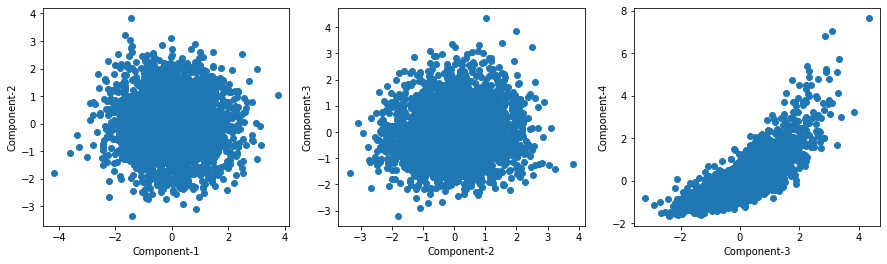

In [44]:
plt.rcParams["figure.figsize"] = (5*(d-1),4)
for i in range(d-1):
    plt.subplot(1,d-1,i+1)
    plt.scatter(samps[:,i], samps[:,i+1])
    plt.xlabel("Component-"+str(i+1))
    plt.ylabel("Component-"+str(i+2))


In [45]:
params = [init_icnn_params(x_layer_widths = [1, 2, 2, 1], y_layer_widths=[1, 3, 3, 1], picnn=False)]

for i in jnp.arange(1,d):
    params.append(init_icnn_params(x_layer_widths = [i, (i+1), (i+1), 1], y_layer_widths=[1, 3, 3, 1], picnn=True))
key, subkey = random.split(key)
params.append(dict(scale= .01*random.multivariate_normal(key, mean=jnp.zeros(d), cov=jnp.identity(d)), bias = .01*random.multivariate_normal(subkey, mean=jnp.zeros(d), cov=jnp.identity(d))))
z0 = jnp.zeros(shape = (d,))
print(flow_forward(params, z0), KL_loss(params, samps))

[-0.01386188 -0.01403505 -0.00500845 -0.00139721] 28.50151


In [46]:
with open('params', 'rb') as file_handle:
    params = pickle.load(file_handle)
print(flow_forward(params, z0), KL_loss(params, samps))

[-3.0174851e-07 -7.8222036e-02 -2.1253672e+00 -1.0341858e+00] 0.55963284


In [47]:
adam = AdamOptim(eta=LEARNING_RATE, beta1=BETA1, beta2=BETA2, epsilon=EPSILON, params=params)
kl = jnp.array([KL_loss(params, samps)])
diff = 10
itr = 0
print("Iter: ", itr, "KL loss: ", kl[itr], "Non-monotonicity metric: ", 0)

while (diff > 1e-8):
    itr += 1
    grads = grad(KL_loss, argnums=0)(params, samps)
    params = adam.update(params, grads, t=itr)
    kl = jnp.hstack((kl, KL_loss(params, samps)))
    diff = jnp.abs((kl[-1] - kl[-2])/kl[-2])
    if(itr % 10 ==0):
        reg = 0
        for i in range(d):
            for layers in params[i]:
                reg += jnp.sum(layers['weights_z'][layers['weights_z'] < 0]**2)
        print("Iter: ", itr, "KL loss: ", kl[itr], "Non-monotonicity metric: ", reg)


Iter:  0 KL loss:  0.55963284 Non-monotonicity metric:  0
Iter:  10 KL loss:  0.7178229 Non-monotonicity metric:  0.0
Iter:  20 KL loss:  0.5316109 Non-monotonicity metric:  2.142129e-06
Iter:  30 KL loss:  0.53042966 Non-monotonicity metric:  0.0
Iter:  40 KL loss:  0.52192676 Non-monotonicity metric:  0.0
Iter:  50 KL loss:  0.5043239 Non-monotonicity metric:  0.0
Iter:  60 KL loss:  0.49735743 Non-monotonicity metric:  0.0
Iter:  70 KL loss:  0.49520248 Non-monotonicity metric:  0.0
Iter:  80 KL loss:  0.49357748 Non-monotonicity metric:  0.0
Iter:  90 KL loss:  0.49227864 Non-monotonicity metric:  0.0
Iter:  100 KL loss:  0.49129882 Non-monotonicity metric:  0.0
Iter:  110 KL loss:  0.49049544 Non-monotonicity metric:  0.0
Iter:  120 KL loss:  0.48979363 Non-monotonicity metric:  0.0
Iter:  130 KL loss:  0.4891582 Non-monotonicity metric:  0.0
Iter:  140 KL loss:  0.48858106 Non-monotonicity metric:  0.0
Iter:  150 KL loss:  0.4880508 Non-monotonicity metric:  0.0
Iter:  160 KL los

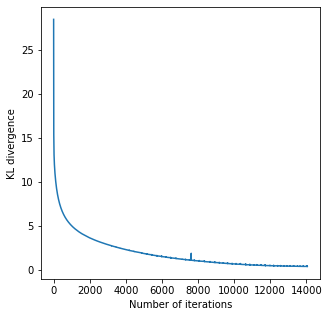

In [20]:
plt.rcParams["figure.figsize"] = (5,5)
plt.xlabel("Number of iterations")
plt.ylabel("KL divergence")
plt.plot(jnp.arange(0, jnp.size(kl)), kl)
plt.savefig('optim_curve.png')

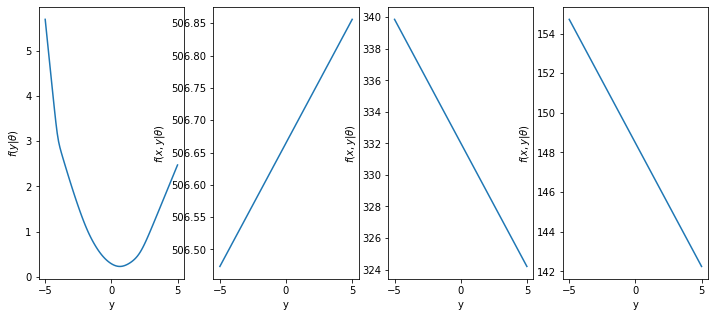

In [48]:
### Plotting the two ICNN f^j with respect to x_j for fixed other inputs

xs = jnp.reshape(jnp.linspace(-5, 5, 100), (100,1))
ys = vec_ficnn(params[0], xs)
plt.rcParams["figure.figsize"] = (3*d,5)
plt.subplot(1,d,1)
plt.plot(xs, ys)
plt.xlabel("y")
plt.ylabel(r"$f(y | \theta)$")
for i in jnp.arange(1,d):
    ys = vec_picnn(params[i], z0[:i], xs)
    plt.subplot(1,d,(i+1).item())
    plt.plot(xs, ys)
    plt.xlabel("y")
    plt.ylabel(r"$f(x,y | \theta)$")
plt.savefig('monotonicity.png')
plt.show()


[0.9997055 1.0002619 0.8659818 0.9999094]


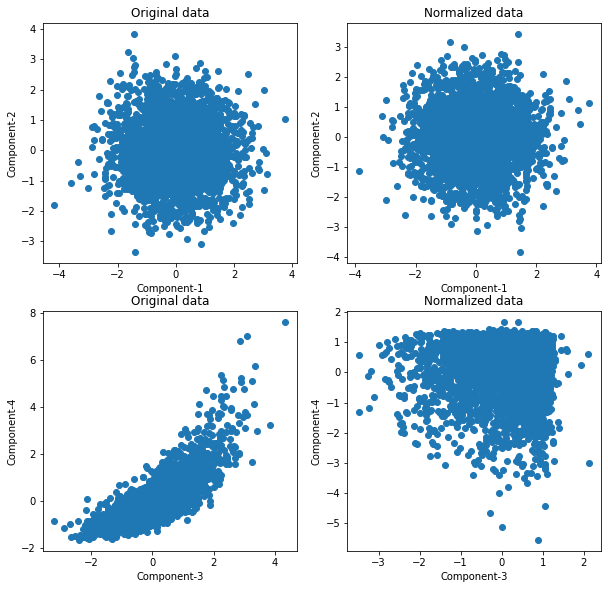

In [49]:
z = vec_flow(params, samps)
print(jnp.std(z, axis = 0))
plt.rcParams["figure.figsize"] = (10,5*(d-1))
for i in range(2):
    plt.subplot((d-1),2,(2*i+1))
    plt.scatter(samps[:,2*i], samps[:,2*i+1])
    plt.xlabel("Component-"+str(2*i+1))
    plt.ylabel("Component-"+str(2*i+2))
    plt.title("Original data")
    plt.subplot((d-1),2,(2*i+2))
    plt.scatter(z[:,2*i],z[:,2*i+1])
    plt.xlabel("Component-"+str(2*i+1))
    plt.ylabel("Component-"+str(2*i+2))
    plt.title("Normalized data")
    plt.show
plt.savefig('scatterplot.png')
    

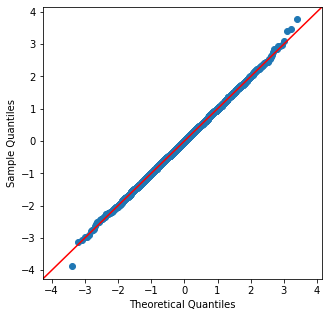

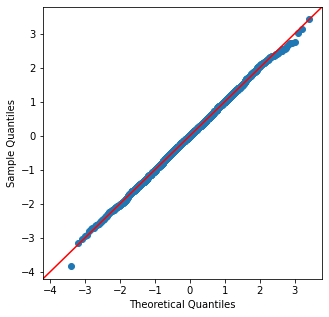

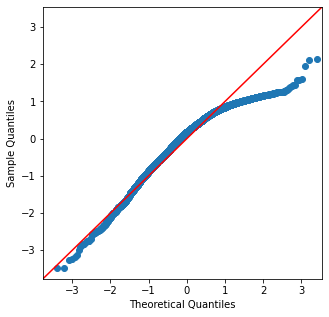

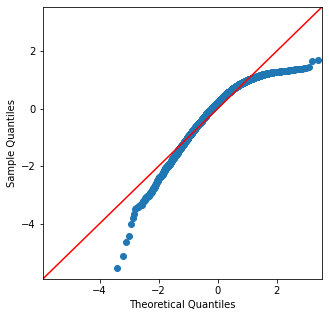

In [50]:
plt.rcParams["figure.figsize"] = (5,5)
for t in range(d):
    fig = sm.qqplot(z[:,t], line = '45')
    plt.savefig('qq_plots'+str(t+1)+'.png')
    plt.show()


In [51]:
with open('params', 'wb') as file_handle:
    pickle.dump(params, file_handle)